In [46]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import wandb

random.seed(27)
np.random.seed(27)
plt.style.use('ggplot')

>### **This notebook, will support our report with the techincal implementation. Assume that the methods we use are either from week 1-2, and from the "understanding deep learning" prince chapter 3-4-5-6-7-8-9. If not, we will specify from where the method is from.**

## Section 1: Dataset

In [47]:
# Pick dataset, 
ds = "mnist"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [48]:

mnist_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=None)
mnist_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=None)

X_train = mnist_train.data.to(torch.float32).numpy()
y_train = mnist_train.targets.to(torch.int64).numpy()

X_test  = mnist_test.data.to(torch.float32).numpy()
y_test  = mnist_test.targets.to(torch.int64).numpy()

# Normalize the pixel values (important for neural nets)
X_train /= 255.0
X_test /= 255.0

# Flatten
X_train = X_train.reshape(-1, np.prod(X_train.shape[1:]))
X_test = X_test.reshape(-1, np.prod(X_test.shape[1:]))

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (60000, 784) (60000,)
Test shape: (10000, 784) (10000,)


In [49]:
def one_hot_encode(y, num_classes=10):
    y_encoded = np.zeros((num_classes, y.size))
    y_encoded[y, np.arange(y.size)] = 1
    return y_encoded

#FashionMNSIT had 10 calsses
Y_train = one_hot_encode(y_train, 10)  
Y_test  = one_hot_encode(y_test, 10)  


print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test: ", X_test.shape,  "Y_test: ",  Y_test.shape)

X_train: (60000, 784) Y_train: (10, 60000)
X_test:  (10000, 784) Y_test:  (10, 10000)


Since we're dealing with feed forward neural networks (and e.g., not CNNs), we need to flatten the image-tensor for each input. E.g., for a $4 \times 4$ grayscale image tensor, we flatten it as such:
$$
x_i =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix} \in \mathbb{R}^{4 \times 4}
, \qquad
\mathrm{flatten}(x_i) =
\begin{bmatrix}
1 & 2 & 3 & 4 &
5 & 6 & 7 & 8 &
9 & 10 & 11 & 12 &
13 & 14 & 15 & 16
\end{bmatrix}^T \in \mathbb{R}^{16 \times 1}
$$

Do note that this approach is greedy, and might destory spatial features that eg a RGB picture could give. 

### One-hot encoding of class labels

Later, we must calculate the loss using cross-entropy of the softmax output, so each class label must be transformed into a one-hot encoded vector.

For a classification problem with \(C\) classes, a label


$y_i \in \{0, 1, \ldots, C-1\}$

is encoded as

$$
\mathrm{onehot}(y_i) =
\begin{bmatrix}
0 \\ \vdots \\ 1 \\ \vdots \\ 0
\end{bmatrix}
$$

where the component corresponding to the class index 

> Source: Week 1-2 jupyter

## Section 2: Feedforward Neural Network

### 2.1: Forward measure

Given input $\bm{x} \in \mathbb{R}^D$ and outputs $\bm{y} \in \mathbb{R}^K$:
$$
\bm{x} = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_D
\end{bmatrix}
, \qquad
\bm{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_O
\end{bmatrix}
$$

we can construct a feed-forward network using basis functions. We can write it as the following recurrence relation.

The first layer is:
$$
a_j^{(1)} = \sum^{D}_{i=1} w_{j,i}^{(1)} x_i + w_{j,0}^{(1)}, \qquad z_i^{(0)} = x_i
$$

where $i = 1, \dots, D$ and $j = 1, \dots, D_{1}$, we are essentially just making $D_{1}$ linear combinations of the inputs $x_1, \dots, x_D$ with $w_{j,i}^{(1)}$ and $w_{j,0}^{(1)}$, which are the weights and biases of the first layer. Here $z_i^{(0)}$ are the hidden units, which in the first layer is just the input.

The first layer is then connected to the second layer:
$$
a_k^{(2)} = \sum^{D_{1}}_{j=1} w_{k,j}^{(2)} z_j^{(1)} + w_{k,0}^{(2)}, \qquad z_j^{(1)} = h\left( a_j^{(1)} \right)
$$

with $k = 1, \dots, D_{2}$.

Note here that we use an activation function $h(\cdot)$ to non-linearize the pre-activations so that they can perform smooth fits of points. These activation functions need to be properly differentiable, so that they can be used in a forward- and backward-propagation chain. That is, both $h(\cdot) = \mathrm{forward}(\cdot)$ and $h'(\cdot) = \mathrm{backward}(\cdot)$ need to be properly defined.

We then have the necessary prerequisites to generalize the recurrence relation, so for layers $l = 1, 2, \dots, L$:

$$
a_\alpha^{(l)} = \sum^{D_{l-1}}_{\beta=1} w_{\alpha, \beta}^{(l)} z_\beta^{(l-1)} + w_{\alpha, 0}^{(l)}, \qquad z_\beta^{(l-1)} = h\left( a_\beta^{(l-1)} \right)
$$

where $w_{\alpha,\beta}^{(l)}$ are the weights and $w^{(l)}_{\alpha, 0}$ are the biases of the $l$'th layer.

Note here that all $a_\alpha^{(l)}$ are known as pre-activations and $z_\beta^{(l)}$ are known as post-activations.

Finally, we have the output units:
$$
y_o(\bm{x}, \bm{w}) = z_r^{(L)} = h_L\left(a_r^{(L)} \right) = f\left(a_r^{(L)} \right)
$$

in which the "activation" function is changed into a prediction function $f$ to get probabilities $p_o \in [0, 1]$. Most often softmax is used.

All of this can also be written in vector/matrix notation, which is the kind that we will use in this project (since the vectorization of operations is more efficient):
$$
\bm{X} =
\begin{bmatrix}
\vert & \vert & & \vert\\
\bm{x}^{(1)} & \bm{x}^{(2)} & \dots & \bm{x}^{(m)} \\
\vert & \vert & & \vert
\end{bmatrix} \in \mathbb{R}^{D \times m}
$$
where $m$ is number of samples and $D$ is input dimensionality.

For a network with $L$ layers $l = 1, 2, \dots, L$, we have the recurrence relation:
$$
\bm{A}^{1} = \bm{W}^{(1)} \bm{X} + \bm{b}^{(1)}, \qquad \bm{Z}^{(0)} = \bm{X}, \qquad \bm{W}^{(1)} \in \mathbb{R}^{D_1 \times D}, \qquad \bm{b}^{(1)} \in \mathbb{R}^{D_1}
$$

$$
\bm{A}^{2} = \bm{W}^{(2)} \bm{Z}^{(1)} + \bm{b}^{(2)}, \qquad \bm{Z}^{(1)} = h\left( \bm{A}^1 \right), \qquad \bm{W}^{(2)} \in \mathbb{R}^{D_2 \times D_1}, \qquad \bm{b}^{(2)} \in \mathbb{R}^{D_2}
$$

$$
\bm{A}^{(l)} = \bm{W}^{(l)} \bm{Z}^{(l-1)} + \bm{b}^{(l)}, \quad \bm{Z}^{(l-1)} = h\left( \bm{A}^{l-1} \right), \qquad \bm{W}^{(l)} \in \mathbb{R}^{D_l \times D_{l-1}}, \qquad \bm{b}^{(l)} \in \mathbb{R}^{D_l}
$$

$$
\bm{Y}(\bm{x}, \bm{w}) = \bm{Z}^{(L)} = f \left( \bm{A}^L \right)
$$

where the bias vector $\bm{b}^{(l)}$ is broadcast across all $l$ units.

> Source: Week 1-2, (Understanding Deep Learning, Simon J.D. Prince, chapter 3-4) 

### 2.2 Activation functions

Programatically, we just need activation functions to support both forward and backward propagation for a layer. Forward propagation simply uses the base function (non-derivative). Backward propagation uses the first order derivative of the function itself. As discussed previously:
$$
h(x) = \mathrm{forward}(x), \qquad h'(x) = \mathrm{backward}(x)
$$

For example, the ReLU activation function:
$$
\mathrm{ReLU}(x) = \max(0,x) =
\begin{cases}
0 & \text{if } x \leq 0 \\
x & \text{if } x > 0
\end{cases}
, \qquad

\mathrm{ReLU}'(x) =
\begin{cases}
0 & \text{if } x \leq 0 \\
1 & \text{if } x > 0
\end{cases}
$$

so we simply just construct an `Activation` function class with `forward` and `backward` methods.

In [50]:
from NN.activations import *

### 2.3 Initializer

An `Initializer` class to initialize parameters $\bm{\Omega}^{(l)} = \{ \bm{W}^{(l)}, \bm{b}^{(l)} \}$ so that activations maintain stable variance across layers.

The key idea (Bishop, UDL book) is that if weights are too large, variance explodes and if it's too small, variance shrinks, so we try to scale parameters such that:
$$
\mathrm{Var}\left(\bm{A}^{(l)} \right) \approx \mathrm{Var}\left(\bm{Z}^{(l-1)} \right)
$$

Below we will exemplify this through He initialization using the ReLU activation function ($h(\cdot) = \mathrm{ReLU}(\cdot)$).

Assuming biases $b_{\alpha}^{(l)} = w^{(l)}_{\alpha, 0}$ are initialized to zero and weights and inputs are i.i.d., and independent of one another.

#### Variance of a single pre-activation
Consider one hidden unit $\alpha$ in layer $l$:
$$
a^{(l)} = \sum^{D_{l-1}}_{\beta = 1} w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} + b_{\alpha}^{(l)}
$$

Since $b_{\alpha}^{(l)} = 0$:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = \mathrm{Var}\left( \sum^{D_{l-1}}_{\beta = 1} w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} \right) 
$$

Using that $w^{(l)}_{\alpha, \beta}$ and $z^{(l-1)}_{\beta}$ are independent and also i.i.d. for all $\beta$:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = \sum^{D_{l-1}}_{\beta = 1} \mathrm{Var}\left( w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} \right) = D_{l-1} \mathrm{Var}\left( w^{(l)}_{\alpha, \beta} z^{(l-1)}_{\beta} \right) 
$$

For two independent random variables:
$$
\mathrm{Var}(X Y) = \mathrm{Var}(X) \mathrm{Var}(Y) + (\mathbb{E}[X])^2 \mathrm{Var}(Y) + (\mathbb{E}[Y])^2 \mathrm{Var}(X)
$$

Applying this, we get:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \left( \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \mathrm{Var}\left( z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ w_{\alpha, \beta}^{(l)} \right] \right)^2 \cdot \mathrm{Var}\left(z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right] \right)^2 \cdot \mathrm{Var}\left(w_{\alpha, \beta}^{(l)} \right) \right)
$$

Since weights are initialized with $w \sim \mathcal{N}(0, \mathrm{Var}(w))$, we have $\mathbb{E}\left[ w_{\alpha, \beta}^{(l)} \right] = 0$, so the above is reduced to:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \left( \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \mathrm{Var}\left( z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right] \right)^2 \cdot \mathrm{Var}\left(w_{\alpha, \beta}^{(l)} \right) \right)
$$

Factor out $\mathrm{Var}\left(w_{\alpha, \beta}^{(l)} \right)$:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left( \mathrm{Var}\left( z_\beta^{(l-1)} \right) + \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right] \right)^2 \right)
$$

Using the definition of variance we have $\mathrm{Var}(X) + \left(\mathbb{E}\left[ X \right] \right)^2 = \mathbb{E}\left[X^2 \right]$. We can apply this:
$$
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) = D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right]^2 \right)
$$

#### Expected squared expectation for ReLU
Because $a^{(l-1)}_{\beta} \sim \mathcal{N}\left(0, \mathrm{Var}\left( a^{(l-1)}_{\beta} \right) \right)$ and $z_\beta^{(l-1)} = \mathrm{ReLU}\left( a^{(l-1)}_{\beta} \right)$, we obtain:
$$
\begin{align*}
\mathbb{E}\left[\left(z_\beta^{(l-1)} \right)^2 \right] &= \int^{\infty}_{-\infty} \left( \mathrm{ReLU}\left( a^{(l-1)}_{\beta} \right) \right)^2 \cdot f_{a^{(l-1)}_{\beta}} \left( a_\beta^{(l-1)} \right) \, \mathrm{d}\left(a_\beta^{(l-1)} \right) \\
&= \int^{\infty}_{0} \left( a^{(l-1)}_{\beta} \right)^2 \cdot f_{a^{(l-1)}_{\beta}} \left( a_\beta^{(l-1)} \right) \, \mathrm{d}\left(a_\beta^{(l-1)} \right) \qquad \text{since } \mathrm{ReLU} = 0 \text{ for } a < 0 \\
\end{align*}
$$

Using symmetry:
$$
\begin{align*}
\mathbb{E}\left[\left(z_\beta^{(l-1)} \right)^2 \right] &= \frac{1}{2} \int^{\infty}_{-\infty} \left( a^{(l-1)}_{\beta} \right)^2 \cdot f_{a^{(l-1)}_{\beta}} \left( a_\beta^{(l-1)} \right) \, \mathrm{d}\left(a_\beta^{(l-1)} \right) \\
&= \frac{1}{2} \mathbb{E}\left[ \left( a^{(l-1)}_{\beta} \right)^2 \right] \\
&= \frac{1}{2} \mathrm{Var}\left( a^{(l-1)}_{\beta} \right) \qquad \text{since zero mean} 
\end{align*}
$$

So for ReLU, we have:
$$
\mathrm{Var}\left( z^{(l-1)}_{\beta} \right) = \mathbb{E}\left[\left(z_\beta^{(l-1)} \right)^2 \right] = \frac{1}{2} \mathrm{Var}\left( z^{(l-1)}_{\beta} \right)
$$

Returning to the variance of the pre-activation:
$$
\begin{align*}
\mathrm{Var}\left( a^{(l)}_{\alpha} \right) &= D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left(\mathbb{E}\left[ z_\beta^{(l-1)} \right]^2 \right) \\
&= D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \cdot \left( \frac{1}{2} \mathrm{Var}\left( z^{(l-1)}_{\beta} \right) \right) \\
&= \frac{1}{2} D_{l-1} \mathrm{Var}\left( w_{\alpha, \beta}^{(l)} \right) \mathrm{Var}\left( z^{(l-1)}_{\beta} \right)
\end{align*}
$$

#### Variance across all layers
We relate this to the recurrence relation defined earlier. Recall that $\bm{Z}^{(0)} = \bm{X}$, then for $l = 1, \dots, L$:
$$
\mathrm{Var}\left( \bm{A}^{(l)} \right) = D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \mathrm{Var}\left( \bm{Z}^{(l-1)} \right)
$$

and for ReLU we have $\mathrm{Var}\left( \bm{Z}^{(l)} \right) = \frac{1}{2} \mathrm{Var}\left( \bm{A}^{(l)} \right)$:
$$
\mathrm{Var}\left( \bm{A}^{(l)} \right) = D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \mathrm{Var}\left( \bm{Z}^{(l-1)} \right)
$$

so recursively, for the last layer:
$$
\mathrm{Var}\left( \bm{A}^{(L)} \right) = \mathrm{Var}\left( \bm{Z}^{(0)} \right) \prod^{L}_{l=1} \left( \frac{1}{2} D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \right)
$$

#### Weight initialization
To maintain stable variance while propagating layers we must have:
$$
\frac{1}{2} D_{l-1} \mathrm{Var}\left( \bm{W}^{(l)} \right) \approx 1
$$

Solving for variance:
$$
\mathrm{Var}\left( \bm{W}^{(l)} \right) \approx \frac{2}{D_{l-1}}
$$

Inserting this into the distribution:
$$
W^{(l)}_{\alpha, \beta} \sim \mathcal{N}\left( 0, \frac{2}{D_{l-1}} \right)
$$

which gives He initialization. 

Note here that $D_{l-1}$ is equivalent to `n_in`.

> Source is chapter 7 in prince, bishop UDL book from signals & data course

In [51]:
from NN.initializer import *

### 2.4 Layers

We now construct a `Layer` class to handle all forward and backward propagation. We then create a `DenseLayer` which is synonymous with a fully connected layer, i.e. a layer in which every neuron (hidden unit) in layer $l$ is connected with every neuron in $l-1$.

Here we also make use of the `Initializer` and `Activation` classes we made. Furthermore, we have also introduced L2 regularization to encourage smoother weights (UDL book).

In [52]:
from NN.denseLayer import *

Quick test, output as a probability distribution:

In [53]:
layer1 = DenseLayer(
    n_in=X_train.shape[1],
    n_out=15,
    activation=ReLU(),
    initializer=HeInitializer()
)
output_layer = DenseLayer(
    n_in=15,
    n_out=10,
    activation=Softmax(),
    initializer=NormalInitializer() #In this we just set initialiser to normal, however given None, it will automaticly detect what initialiser to use
)

A1 = layer1.forward(X_train.T)      # ReLU
A2 = output_layer.forward(layer1.Z) # SoftMax

sample_probs = A2[:, 0]      # first sample
print(sample_probs)
print(sum(sample_probs))     # should be 1.0

[0.09870661 0.10201467 0.10157728 0.10124532 0.10160944 0.09780518
 0.09417268 0.09979802 0.10433105 0.09873976]
0.9999999999999999


In [54]:
print(layer1)

DenseLayer(784 -> 15, Activation=ReLU)
Weights shape: (15, 784), min: -0.181879, max: 0.193472, mean: -0.000298
Biases shape: (15, 1), min: 0.000000, max: 0.000000, mean: 0.000000


### 2.5 Loss

Here we have a class for `Loss` functions. We've implemented `CrossEntropyLoss` for multi-class classification. Again, we follow the same design-paradigm with `forward` and `backward` class methods.

We can derive the Cross Entropy loss function as follows. We have a training set $\mathcal{D} = \{ (\bm{x}_n, \bm{t}_n) : n = 1, \dots, N \}$. The loss (or error) is then a measure of how far $\bm{y}(\bm{x}, \bm{w})$ is from the target data.

#### Softmax
For a minibatch of size $m$, the final pre-activations are:
$$
\bm{A}^{(L)} \in \mathbb{R}^{K \times m}
$$

where each column $\bm{a}^{(L)}_n$ is the $K$-vector of logits for example $n$.

In case we wanted to use the whole dataset, we'd set $m=N$.

We define the softmax output:
$$
\bm{Y}(\bm{x}, \bm{w}) = \mathrm{softmax}\left( \bm{A}^{(L)} \right), \qquad \bm{Y}_{k,n} = \frac{\exp\left( A^{(L)}_{k,n} \right)}{\sum^{K}_{j=1} \exp\left( A^{(L)}_{j,n} \right)}
$$

Targets for the minibatch are then encoded as one-hot (or probabilities) in:
$$
\bm{T} \in \mathbb{R}^{K \times m}, \qquad T_{k,n} \in \{ 0, 1 \}, \qquad \sum^{K}_{k=1} T_{k,n} = 1
$$

#### Cross Entropy loss
The likelihood for one example $n$ under the model is:
$$
P(\bm{t}_n \mid \bm{x}_n, \bm{w}) = \prod^{K}_{k=1} \left[ \bm{Y}_k(\bm{x}_n) \right]^{T_{k,n}}
$$

Using negative log likelihood, we get the loss (for the whole minibatch):
$$
L(\bm{w}) = -\log\left( \prod^{m}_{n=1} \left( \prod^{K}_{k=1} \left[ \bm{Y}_k(\bm{x}_n) \right]^{T_{k,n}} \right) \right) = - \sum^{m}_{n=1} \sum^{K}_{k=1} T_{k,n} \log\left( \bm{Y}_{k,n} \right)
$$

The batched-average loss:
$$
L(\bm{w}) = - \frac{1}{m} \sum^{m}_{n=1} \sum^{K}_{k=1} T_{k,n} \log\left( \bm{Y}_{k,n} \right)
$$

#### Derivative w.r.t. logits
We need the gradient $\frac{\partial L}{\partial A^{(L)}_{j,n}}$ for a single sample $n$. First we calculate the loss:
$$
L^{(n)} = -\sum^{K}_{k=1} t_k \log(y_k), \qquad y_k = \frac{\exp\left( A^{(L)}_{k,n} \right)}{\sum_{j} \exp\left( A^{(L)}_{j,n} \right)}
$$

We get the result:
$$
\frac{\partial L}{\partial A^{(L)}_{j,n}} = Y_{j,n} - T_{j,n}
$$

for each class index $j$.

Since we do this vectorized, we have gradient:
$$
\bm{G} := \frac{\partial L}{\partial \bm{A}^{(L)}} \in \mathbb{R}^{K \times m}
$$

and elementwise we have:
$$
\bm{G} = \frac{1}{m} (\bm{Y} - \bm{T})
$$

#### Gradients for final layer
The final layer will output $\bm{A}^{(L)} = \bm{W}^{(L)} \bm{Z}^{(L-1)} + \bm{b}^{(L)}$ where $\bm{Z}^{(L-1)} \in \mathbb{R}^{D_{L-1} \times m}$ are activations from the previous layer.

Using $\bm{G} = \frac{\partial L}{\partial \bm{A}^{(L)}} = \frac{1}{m} (\bm{Y} - \bm{T})$, the gradients we get are:
$$
\frac{\partial L}{\partial \bm{W}^{(L)}} = \bm{G} \left(\bm{Z}^{(L-1)}\right)^T \in \mathbb{R}^{K \times D_{L-1}}, \qquad \frac{\partial L}{\partial \bm{b}^{(L)}} = \bm{G} \bm{1}_m = \frac{1}{m} \sum^{m}_{n=1} (\bm{Y}_{:,n} - \bm{T}_{:,n}) \in \mathbb{R}^{K}
$$

If L2 regularization is included, simply add $\lambda \bm{W}^{(L)}$ to $\frac{\partial L}{\partial \bm{W}^{(L)}}$.

The gradient we pass to the previous layer is then:
$$
\frac{\partial L}{\partial \bm{Z}^{(L-1)}} = \left( \bm{W}^{(L)} \right)^T \bm{G}
$$

In [55]:
from NN.loss import *

### 2.6 Optimizer

The goal of an `Optimizer` is to find the parameters that minimize the loss. It uses the gradients with respect to the parameters $\bm{W}$ and $\bm{b}$ to do so. At each iteration it updates the weights wrt. a defined magnitude $\alpha$, that decides how much the parameters will change, and the gradients:
$$
\bm{W} \leftarrow \bm{W} - \alpha_{\bm{W}} \cdot \frac{\partial L}{\partial \bm{W}}, \qquad \bm{b} \leftarrow \bm{b} - \alpha_{\bm{b}} \cdot \frac{\partial L}{\partial \bm{b}}
$$

Here we implemented `SGD` (stochastic gradient descent), without momentum, which has a fixed step size and `Adam` (adaptive moment estimation). 

The main differences between the two is that SGD has a single learning rate for all parameters, where Adam has multiple learning rates.

In [56]:
from NN.optimizer import *

### 2.7 Network

Forward pass:

In [57]:
NN = [
    DenseLayer(X_train.shape[1], 15, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(15, 10, activation=Softmax(), initializer=NormalInitializer())
]

def forward(input, network):
    x = input.T  # transpose: (features, batch)
    for layer in network:
        x = layer.forward(x)
    return x

print(forward(X_train, NN))

[[0.10160114 0.10376081 0.10058171 ... 0.103397   0.10109125 0.10073226]
 [0.0975293  0.09456485 0.09922755 ... 0.09651562 0.09879197 0.09916673]
 [0.09967127 0.099807   0.10045652 ... 0.10286542 0.09982896 0.10157053]
 ...
 [0.09819887 0.09744936 0.09950998 ... 0.09834698 0.09862352 0.09985518]
 [0.10258447 0.10136785 0.10077615 ... 0.10112799 0.10165818 0.10006722]
 [0.10341411 0.10340475 0.10111761 ... 0.10259457 0.10160808 0.10060068]]


Backward pass:

In [58]:
NN = [
    DenseLayer(X_train.shape[1], 15, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(15, 10, activation=Softmax(), initializer=NormalInitializer())
]

output = forward(X_train, NN)

loss_fn = CrossEntropyLoss()
dA = loss_fn.backward(A=output, Y=Y_train)

dA

array([[ 1.63278891e-06, -1.49753718e-05, -1.49928429e-05, ...,
         1.67267691e-06, -1.49824100e-05,  1.66683685e-06],
       [ 1.65322078e-06,  1.66005120e-06,  1.66127710e-06, ...,
         1.65071529e-06,  1.65871277e-06,  1.66149478e-06],
       [ 1.69289123e-06,  1.66742823e-06,  1.67153133e-06, ...,
         1.65839722e-06,  1.66462667e-06,  1.66707221e-06],
       ...,
       [ 1.59947325e-06,  1.61843175e-06,  1.64750506e-06, ...,
         1.61983475e-06,  1.64341427e-06,  1.65749930e-06],
       [ 1.68355851e-06,  1.65492178e-06,  1.66957073e-06, ...,
         1.67452976e-06,  1.66902200e-06,  1.67287168e-06],
       [-1.50164237e-05,  1.66584056e-06,  1.66617074e-06, ...,
         1.69045966e-06,  1.66778871e-06,  1.66165003e-06]],
      shape=(10, 60000))

In [59]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 DenseLayer(784 -> 15, Activation=ReLU)
Weights shape: (15, 784), min: -0.198701, max: 0.205178, mean: 0.000043
Biases shape: (15, 1), min: 0.000000, max: 0.000000, mean: 0.000000
Layer 1 
 DenseLayer(15 -> 10, Activation=Softmax)
Weights shape: (10, 15), min: -0.026312, max: 0.032072, mean: -0.000360
Biases shape: (10, 1), min: 0.000000, max: 0.000000, mean: 0.000000


[None, None]

## Section 3 Train loop, batching and wandb

In [60]:
import os
from getAPI import retrieveApi #Retrives our personal API. Gitignore this.

os.environ['WANDB_API_KEY'] = retrieveApi()



We implement mini-batching for the gradient descent by taking inspiration from this source
> https://medium.com/@lomashbhuva/mini-batch-gradient-descent-a-comprehensive-guide-ba27a6dc4863

In [61]:
def accuracy(preds, Y):
    """
    preds: (classes, batch)
    Y: one-hot labels (classes, batch)
    """
    pred_labels = np.argmax(preds, axis=0)
    true_labels = np.argmax(Y, axis=0)
    return np.mean(pred_labels == true_labels)


##TRAINING WITH MINI BATCHING

def train(X, Y, layers, loss_fn, optimizer, epochs=5, batch_size=64):
    m = X.shape[0]
    losses = []
    accs = []

    for epoch in range(epochs):
        #Here we shuffle data to make it random. 
        perm = np.random.permutation(m)
        X_shuffled = X[perm].T
        Y_shuffled = Y[:, perm]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            # Forward
            A = X_batch
            for layer in layers:
                A = layer.forward(A)

            # Loss
            loss = loss_fn.forward(A, Y_batch)

            # Backward
            dA = loss_fn.backward(A, Y_batch)
            for layer in reversed(layers):
                dA, dW, db = layer.backward(dA)
                optimizer.update(layer, dW, db)

        # Compute accuracy on all data
        A_full = X.T
        for layer in layers:
            A_full = layer.forward(A_full)
        acc = accuracy(A_full, Y)


        epoch_acc = accuracy(A_full, Y)
        losses.append(loss)
        accs.append(epoch_acc)


        wandb.log({
            "loss": loss,
            "accuracy": acc,
            "epoch": epoch + 1
        })

        print(f"Epoch {epoch+1}/{epochs}  loss={loss:.4f}  acc={epoch_acc:.4f}")

    return losses, accs



In [62]:
# Define network architecture, small example
layers = [
    DenseLayer(X_train.shape[1], 128, activation=ReLU(), initializer=None),
    DenseLayer(128, 10, activation=Softmax(), initializer=None) #NOTE None makes it automatic. 
]

# Optimizer
opt = SGD(learning_rate=0.1)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 1/20  loss=2.2915  acc=0.3913
Epoch 2/20  loss=2.2769  acc=0.3906
Epoch 3/20  loss=2.2477  acc=0.3603
Epoch 4/20  loss=2.1926  acc=0.3367
Epoch 5/20  loss=2.1375  acc=0.3299
Epoch 6/20  loss=2.0284  acc=0.3605
Epoch 7/20  loss=1.9173  acc=0.3853
Epoch 8/20  loss=1.7938  acc=0.4089
Epoch 9/20  loss=1.7459  acc=0.4695
Epoch 10/20  loss=1.5984  acc=0.5236
Epoch 11/20  loss=1.4673  acc=0.5555
Epoch 12/20  loss=1.5008  acc=0.5788
Epoch 13/20  loss=1.2985  acc=0.5879
Epoch 14/20  loss=1.3491  acc=0.5982
Epoch 15/20  loss=1.2186  acc=0.6060
Epoch 16/20  loss=1.2071  acc=0.6158
Epoch 17/20  loss=1.1817  acc=0.6199
Epoch 18/20  loss=1.1739  acc=0.6262
Epoch 19/20  loss=0.9764  acc=0.6360
Epoch 20/20  loss=1.0258  acc=0.6431


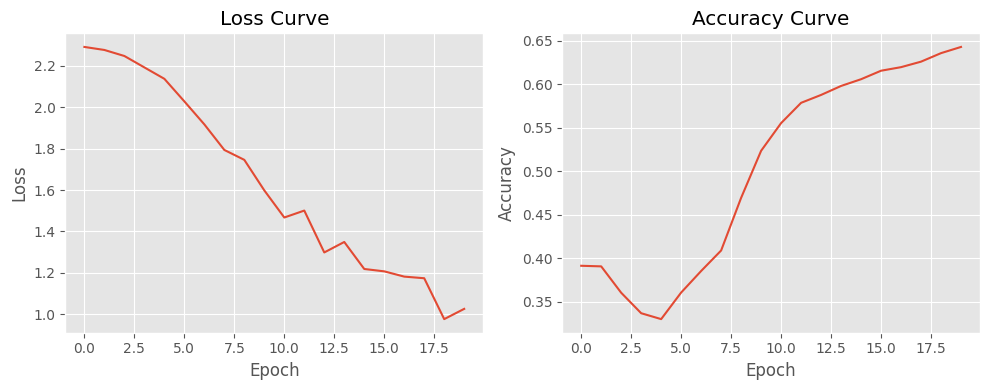

In [63]:
wandb.init(
    project="numpy_nn",
    name="mnist_demo",
    config={
        "epochs": 20,
        "batch_size": 128,
        "learning_rate": 0.01,
        "optimizer": "SGD",
        "loss": "CrossEntropy"
    }
)

losses, accs = train(
    X_train,
    Y_train,
    layers,
    CrossEntropyLoss(),
    opt,
    epochs=20,
    batch_size=128
)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(accs)
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


### Conclusion: We have now created a modular FFN, where we can change hyperparameters, and log using wandb. Now please go to the trainer.ipynb for the hyper parameter study. In this trainer.ipynb, we will create cross validation with sweeps in wandb